In [34]:
import numpy as np
import qiskit as q
from qiskit import QuantumCircuit, transpile, assemble, QuantumRegister, AncillaRegister
from qiskit_aer import AerSimulator

from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex
import matplotlib as mpl
import matplotlib.pyplot as plt

from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram, plot_state_city

import math
import pickle as pkl

In [35]:
#parameters

M = 64 # lattices

dim = 1
dirs = 3

w0 = 2/3
w1 = 1/6 
w2 = 1/6 
e0 = 0
e1 = 1   ##right
e2 = -1  ##left
cs = 1/np.sqrt(3)   ##speed of sound
u = 0.2  ##advection 


x = w1*(1+e1*u/cs**2)
y = w2*(1+e2*u/cs**2)
z = w0*(1+e0*u/cs**2)

lambda1 = np.arccos(x)
lambda2 = np.arccos(y)
lambda0 = np.arccos(z)
lambdas = (lambda0, lambda1, lambda2)

x,y,z

(np.float64(0.2666666666666666),
 np.float64(0.06666666666666668),
 np.float64(0.6666666666666666))

In [36]:
def createLambda(oper, isC1 = True):
    
    if oper == 0:
        s = '10'
    elif oper == 1:
        s = '00'
    else:
        s = '01'
    
    nlambda = lambdas[oper]
    
    if not isC1:
        nlambda*=-1
    
    qc = QuantumCircuit(dirs)
    
    tmp = QuantumCircuit(1)

    tmp.p(nlambda, 0)
    tmp.x(0)
    tmp.p(nlambda, 0)
    tmp.x(0)
    
    gate = tmp.to_gate(label = "Lambda"+str(oper)).control(1, ctrl_state=int(s[1])).control(1,ctrl_state = int(s[0]))
    
    qc.append(gate,list(range(dirs))[::-1])
    return qc

In [37]:
def rshift(n):
    circ = QuantumCircuit(n)
    for i in range(n):
        if i == n-1:
            circ.x(i)
        else:
            circ.mcx(list(range(i+1,n)), i)
    return circ

def lshift(n):
    circ = QuantumCircuit(n)
    for i in reversed(range(n)):
        if i == n-1:
            circ.x(i)
        else:
            circ.mcx(list(range(i+1,n)), i)
    return circ

def prop(n):
    R = rshift(n).to_gate(label = "R").control(1, ctrl_state = 0)#.control(0, ctrl_state = 1)
    L = lshift(n).to_gate(label = "L").control(1, ctrl_state = 1)#.control(0, ctrl_state = 1)
    
    cbits = [n]
    cbits.extend([i for i in range(n-1,-1,-1)])  
    
    qc = QuantumCircuit(n+1)
    qc.append(R,cbits)
    qc.append(L,cbits)
    return qc
lshift(5).draw()

┌───┐
q_0: ────────────────────┤ X ├
                    ┌───┐└─┬─┘
q_1: ───────────────┤ X ├──■──
               ┌───┐└─┬─┘  │  
q_2: ──────────┤ X ├──■────■──
          ┌───┐└─┬─┘  │    │  
q_3: ─────┤ X ├──■────■────■──
     ┌───┐└─┬─┘  │    │    │  
q_4: ┤ X ├──■────■────■────■──
     └───┘

In [38]:
q = QuantumRegister(np.ceil(np.log2(dirs))+np.log2(M),'q')
a = AncillaRegister(1,'a')


setup = QuantumCircuit(q)
setup.add_register(a)

setup.h(a)
setup.append(createLambda(0,True).to_gate(label = 'lambda0').control(1,ctrl_state = 0),[a,0,6,7])
setup.append(createLambda(1,True).to_gate(label = 'lambda1').control(1,ctrl_state = 0),[a,0,6,7])
setup.append(createLambda(2,True).to_gate(label = 'lambda2').control(1,ctrl_state = 0),[a,0,6,7])
setup.append(createLambda(0,False).to_gate(label = 'lambda0').control(1,ctrl_state = 1),[a,0,6,7])
setup.append(createLambda(1,False).to_gate(label = 'lambda1').control(1,ctrl_state = 1),[a,0,6,7])
setup.append(createLambda(2,False).to_gate(label = 'lambda2').control(1,ctrl_state = 1),[a,0,6,7])
setup.h(a)

# setup.barrier()
setup.append(rshift(6).to_gate(label = "R").control(1, ctrl_state = 0).control(1,ctrl_state=0),[6,7,5,4,3,2,1,0])
setup.append(lshift(6).to_gate(label = "L").control(1, ctrl_state = 0).control(1,ctrl_state=1),[6,7,5,4,3,2,1,0])
# setup.barrier()

# setup.swap(a,6)
# setup.h(a)
# setup.swap(a,7)
# setup.h(a)
setup.h(6)
setup.h(7)

setup.draw()

┌──────────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐»
q_0: ─────┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├»
          │          ││          ││          ││          ││          │»
q_1: ─────┤          ├┤          ├┤          ├┤          ├┤          ├»
          │          ││          ││          ││          ││          │»
q_2: ─────┤          ├┤          ├┤          ├┤          ├┤          ├»
          │          ││          ││          ││          ││          │»
q_3: ─────┤          ├┤          ├┤          ├┤          ├┤          ├»
          │  lambda0 ││  lambda1 ││  lambda2 ││  lambda0 ││  lambda1 │»
q_4: ─────┤          ├┤          ├┤          ├┤          ├┤          ├»
          │          ││          ││          ││          ││          │»
q_5: ─────┤          ├┤          ├┤          ├┤          ├┤          ├»
          │          ││          ││          ││          ││          │»
q_6: ─────┤1         ├┤1         ├┤1         ├┤1         ├┤1         ├»
          │          ││          ││          ││          ││          │»
q_7: ─────┤2         ├┤2         ├┤2         ├┤2         ├┤2         ├»
     ┌───┐└────┬─────┘└────┬─────┘└────┬─────┘└────┬─────┘└────┬─────┘»
  a: ┤ H ├─────o───────────o───────────o───────────■───────────■──────»
     └───┘                                                            »
«     ┌──────────┐┌────┐┌────┐     
«q_0: ┤0         ├┤5   ├┤5   ├─────
«     │          ││    ││    │     
«q_1: ┤          ├┤4   ├┤4   ├─────
«     │          ││    ││    │     
«q_2: ┤          ├┤3   ├┤3   ├─────
«     │          ││  R ││  L │     
«q_3: ┤          ├┤2   ├┤2   ├─────
«     │  lambda2 ││    ││    │     
«q_4: ┤          ├┤1   ├┤1   ├─────
«     │          ││    ││    │     
«q_5: ┤          ├┤0   ├┤0   ├─────
«     │          │└─┬──┘└─┬──┘┌───┐
«q_6: ┤1         ├──o─────■───┤ H ├
«     │          │  │     │   ├───┤
«q_7: ┤2         ├──o─────o───┤ H ├
«     └────┬─────┘┌───┐       └───┘
«  a: ─────■──────┤ H ├────────────
«                 └───┘

In [39]:
#### initialState
initState = np.ones(M)/10  #0.1 everywhere
initState[12] = 0.2
nrm = np.linalg.norm(initState)
initState = np.concatenate((initState,initState,initState,[0 for i in range(M)]))


SV = Statevector(initState/np.linalg.norm(initState)).expand([1,0])
initSV = SV
array_to_latex(SV,max_size = 256)

<IPython.core.display.Latex object>

In [40]:
def timestep(sv):
    return sv.evolve(setup)

def graph(sv, color = "red"):
    plt.plot(list(range(0,M,1)), np.array(sv)[:M:1],color)
    plt.plot(list(range(1*M,2*M,1)), np.array(sv)[1*M:2*M:1],color)
    plt.plot(list(range(2*M,3*M,1)), np.array(sv)[2*M:3*M:1],color)
    plt.plot(list(range(3*M,4*M,1)), np.array(sv)[3*M:4*M:1],color)
    plt.plot(list(range(4*M,5*M,1)), np.array(sv)[4*M:5*M:1],color)
    plt.plot(list(range(5*M,6*M,1)), np.array(sv)[5*M:6*M:1],color)
    plt.plot(list(range(6*M,7*M,1)), np.array(sv)[6*M:7*M:1],color)
    plt.plot(list(range(7*M,8*M,1)), np.array(sv)[7*M:8*M:1],color)

def hres(sv):
    plt.plot(list(range(0,M,1)), nrm* np.array(sv)[:M]/np.linalg.norm(np.array(sv)[:M]))

def reinit(sv):
    tmp = np.array(sv)[:M]
    tmp = np.concatenate((tmp,tmp,tmp,[0 for i in range(M)]))
    return Statevector(tmp/np.linalg.norm(tmp)).expand([1,0])

In [41]:
# sorts and converts values of counts
def process_counts(counts):
    sum = 0
    vals = list(counts.values())
    for i in vals:
        sum = sum + i
    # sort the counts by the keys
    keys = list(counts.keys())
    keys.sort()
    # counts = {i: counts[i] for i in keys}
    # indices = np.argsort(keys)
    counts = {i: counts[i] / sum for i in keys}
    counts = {i: math.sqrt(counts[i]) for i in keys}
    return counts

In [42]:
def simulate_statevector(sv, qc, nshots=10_000):
    simulator = AerSimulator()

    # prepare the state of the given state vector
    circ = QuantumCircuit(qc.num_qubits)
    circ.prepare_state(sv)
    circ.measure_all()
    # TODO: count gates 
    circ = transpile(circ, simulator)
    result = simulator.run(circ, shots=nshots).result()
    counts = result.get_counts(circ)

    return counts

In [43]:
def save_fig(vals, i, type="quantum"):
    plt.xlabel("Lattice Site")
    plt.ylabel("Concentration")
    plt.title(f"Concentration at Lattice Sites at t = {i}")

    plt.plot(list(range(0,M,1)), vals)
    plt.savefig(f'd1q3_{type}_simulation/{i}.png')

    plt.close('all')

In [44]:
#### initialState
def reset_statevector():
    initState = np.ones(M)/10  #0.1 everywhere
    initState[12] = 0.2
    nrm = np.linalg.norm(initState)
    initState = np.concatenate((initState,initState,initState,[0 for i in range(M)]))

    SV = Statevector(initState/np.linalg.norm(initState)).expand([1,0])
    return SV

/Users/melod/anaconda3/envs/qiskit1/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/melod/anaconda3/envs/qiskit1/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


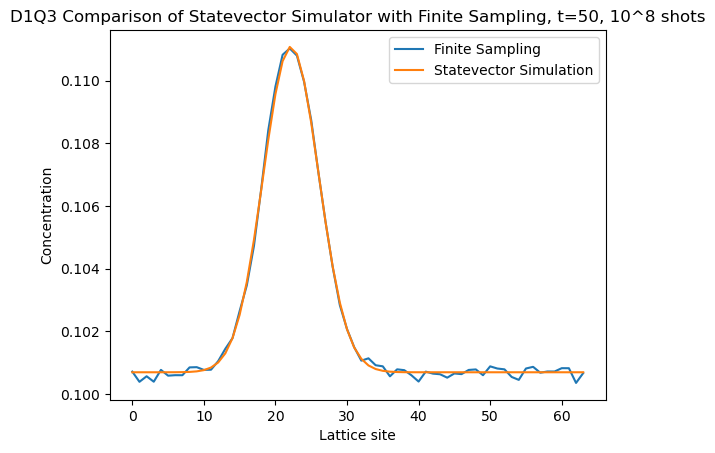

In [45]:
## saves and graphs the change in % difference with increase in number of shots

# hres(initSV)
iterations = 50
lower_pow = 8
upper_pow = 8
SV = reset_statevector()

type = "shots_comparison"

counts_all = {}
sv_all = {}

SV = reset_statevector()

counts_all = {}
sv_all = {}

for j in range(lower_pow, upper_pow + 1):
    for i in range(iterations + 1):
        SV = timestep(SV)

        if i == 50:
            counts = simulate_statevector(SV, setup, nshots=pow(10, j))
            processed_counts = process_counts(counts)

            vals = np.array(list(processed_counts.values())) 
            plt.plot(list(range(0,M,1)), nrm*vals[:M]/np.linalg.norm(np.array(vals[:M])), label='Finite Sampling')
            plt.plot(list(range(0,M,1)), nrm*np.array(SV)[:M]/np.linalg.norm(np.array(SV)[:M]), label='Statevector Simulation')
            
            plt.xlabel("Lattice site")
            plt.ylabel("Concentration")
            plt.title(f'D1Q3 Comparison of Statevector Simulator with Finite Sampling, t={i}, 10^{j} shots')

        SV = reinit(SV)

plt.legend()
plt.show()


In [46]:
counts_all[(5, 10)]

KeyError: (5, 10)

In [56]:
import pickle as pkl

with open('data/d1q3_sampleincr_counts.pkl', 'wb') as f:
    pkl.dump(counts_all, f)

with open('data/d1q3_sampleincr_statevector.pkl', 'wb') as f:
    pkl.dump(sv_all, f)